In [1]:
# Importing standard python libraries
import numpy as np
from math import pi,sqrt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from celluloid import Camera

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import * # plot_bloch_multivector
from ibm_quantum_widgets import * # CircuitComposer
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# Start with an one qubit quantum circuit yielding a nice fractal. Change the circuit as you like.
circuit = QuantumCircuit(1,1)
circuit.h(0)
editor = CircuitComposer(circuit=circuit)
editor

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000015400D539A0>)

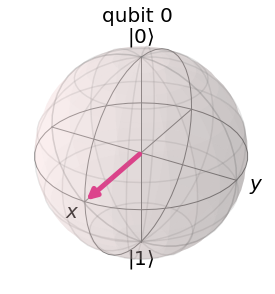

In [3]:
# Generate a Bloch sphere based on the quantum circuit.
qc1 = editor.circuit
plot_bloch_multivector(qc1)

In [4]:
# Run the circuit with the state vector simulator to obtain a noise-free fractal.
backend = Aer.get_backend('statevector_simulator')
out = execute(qc1,backend).result().get_statevector()
#print(out)

# Extract the first element of the state vector as z0 and the second element as z1.
z0 = out.data[0]
z1 = out.data[1]

# Goal for julia_set1CN (below): One complex number for the Julia set fractal. 
if z1.real != 0 or z1.imag != 0:
    z = z0/z1
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0 

#print("z= ",z)

# Define the size of fractal.
size = 1000
heightsize = size
widthsize = size
escapeno = 2


def julia_set1CN(c=z, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)
    
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    
    for i in range(max_iterations):
        z[m] = z[m]**2 + c[m] 
        m[np.abs(z) > escapeno] = False 
        div_time[m] = i
    return div_time


def julia_set2CN1(c0=z0, c1=z1, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize z to all zero
    c0 = np.full(z.shape, c0)
    c1 = np.full(z.shape, c1)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c0.shape, True, dtype=bool)
    for i in range(max_iterations):
        z[m] = (z[m]**2 + c0[m]) / (z[m]**2 + c1[m]) # julia set mating 1
        m[np.abs(z) > escapeno] = False # 2
        div_time[m] = i
    return div_time


def julia_set2CN2(c0=z0, c1=z1, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize z to all zero
    c0 = np.full(z.shape, c0)
    c1 = np.full(z.shape, c1)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c0.shape, True, dtype=bool)
    for i in range(max_iterations):
        z[m] = (c0[m]*z[m]**2 + 1 - c0[m]) / (c1[m]*z[m]**2 + 1 - c1[m]) # julia set mating 2
        m[np.abs(z) > escapeno] = False # 2
        div_time[m] = i
    return div_time

In [5]:
def complexcircuit(tt):
    lqc1 = qc1.copy()
    phl = tt * 2 * pi / frameno
    lqc1.rz(phl,0)
    
    lout = execute(lqc1,backend).result().get_statevector()
    lz0 = lout.data[0]
    lz1 = lout.data[1]

    if lz1.real != 0 or lz1.imag != 0:
            lz = lz0/lz1
            lz = round(lz.real, 2) + round(lz.imag, 2) * 1j
    else:
        lz = 0
            
    return lz, lqc1, lz0, lz1

In [6]:
fig, ax = plt.subplots(1,4, figsize=(20,20)) 
camera = Camera(fig)
    
frameno = 60
for i in range(frameno):
    cno = complexcircuit(i)[0]
    ccircuit = complexcircuit(i)[1]
    cc1 = complexcircuit(i)[2]
    cc2 = complexcircuit(i)[3]
    plot_bloch_multivector(ccircuit, filename='H.png')
    ax[0].imshow(mpimg.imread('H.png'))
    ax[0].axis('off')
    ax[1].imshow(julia_set1CN(c=cno), cmap='magma')
    ax[1].axis('off')
    ax[2].imshow(julia_set2CN1(c0=cc1,c1=cc2), cmap='magma')
    ax[2].axis('off')
    ax[3].imshow(julia_set2CN2(c0=cc1,c1=cc2), cmap='magma')
    ax[3].axis('off')
    camera.snap()
    plt.close()
    
    
anim = camera.animate(blit=True)
anim.save('1qubit_simulator_4animations_H_' + str(frameno) + 'steps.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.
